In [64]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
transactions = pd.read_csv('transactions.csv')

In [3]:
#transactions.amount = transactions.amount.apply(lambda x: round(x/11.2296))

In [4]:
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [5]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2
5,39026145,2 15:53:49,5541,1010,-14643.37,NaN,2


In [6]:
test_transactions = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                                 index=np.arange(1, 31) + train_transactions.day.max())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['mcc_code', 'day']

In [7]:
test_transactions.head()

,mcc_code,day
0,4814,457
1,4814,458
2,4814,459
3,4814,460
4,4814,461


In [8]:
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=train_transactions.day.unique())
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.columns = ['mcc_code', 'day']

In [9]:
train_grid.head()

,mcc_code,day
0,4814,0
1,4814,1
2,4814,2
3,4814,3
4,4814,4


In [10]:
for tr_table in [train_transactions, test_transactions, train_grid]:
    tr_table['week_num'] = tr_table['day'] // 7
    tr_table['week_day'] = tr_table['day'] % 7
    tr_table['month_num'] = tr_table['day'] // 30
    tr_table['month_day'] = tr_table['day'] % 30

In [11]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['day', 'week_num', 'week_day', 'month_num', 'month_day', 'mcc_code'])[['amount']]\
                 .sum().reset_index(),
             how='left').fillna(0)

In [12]:
train_transactions.head()

,mcc_code,day,week_num,week_day,month_num,month_day,amount
0,4814,0,0,0,0,0,-11098744.26
1,4814,1,0,1,0,1,-7881825.53
2,4814,2,0,2,0,2,-6777480.45
3,4814,3,0,3,0,3,-9277943.73
4,4814,4,0,4,0,4,-9999757.21


In [13]:
for day_shift in [-1, 0, 1]:
    for month_shift in train_transactions.month_num.unique()[1:]:
        train_shift = train_transactions.copy()
        train_shift['month_num'] += month_shift
        train_shift['month_day'] += day_shift
        train_shift['amount_day_{}_{}'.format(day_shift, month_shift)] = np.log(-train_shift['amount'] + 1)
        train_shift = train_shift[['month_num', 'month_day', 'mcc_code', 'amount_day_{}_{}'.format(day_shift, month_shift)]]

        train_transactions = pd.merge(train_transactions, train_shift, 
                                      on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)
        test_transactions = pd.merge(test_transactions, train_shift, 
                                     on=['month_num', 'month_day', 'mcc_code'], how='left').fillna(0)


In [14]:
train_transactions.head()

,mcc_code,day,week_num,week_day,month_num,month_day,amount,amount_day_-1_1,amount_day_-1_2,amount_day_-1_3,...,amount_day_1_6,amount_day_1_7,amount_day_1_8,amount_day_1_9,amount_day_1_10,amount_day_1_11,amount_day_1_12,amount_day_1_13,amount_day_1_14,amount_day_1_15
0,4814,0,0,0,0,0,-11098744.26,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4814,1,0,1,0,1,-7881825.53,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4814,2,0,2,0,2,-6777480.45,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4814,3,0,3,0,3,-9277943.73,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4814,4,0,4,0,4,-9999757.21,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
shift = 500
train = pd.get_dummies(train_transactions, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])
c = train.columns.difference(['amount'])

In [16]:
clf = LinearRegression(n_jobs=-1)
clf.fit(train[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1), np.log(-train['amount'] + shift))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [17]:
test_transactions['volume'] = np.e ** clf.predict(test[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1)) - shift

In [18]:
pred_lin = np.e ** clf.predict(test[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1)) - shift

In [19]:
test_transactions[['mcc_code', 'day', 'volume']].head()

,mcc_code,day,volume
0,4814,457,1.161981e+07
1,4814,458,1.184433e+07
2,4814,459,1.194140e+07
3,4814,460,1.184629e+07
4,4814,461,1.208834e+07


In [22]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('baseline_drop.csv', index=False)

## xgb

In [20]:
def RMSLE(y_true,y_pred, shuf):
    return np.sqrt(np.average((np.log(y_true + shuf) - np.log(y_pred + shuf)) ** 2))

In [21]:
import xgboost as xgb

In [22]:
param = {}
param['max_depth'] = 5
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.05
param['subsample'] = 0.7
param['colsample_bytree'] = 0.8
param['colsample_bylevel'] = 0.8

numround = 100

In [25]:
day_for_train = train_transactions.day.max() - 30

In [26]:
X_train = train_transactions[train_transactions.day <= day_for_train]
X_val = train_transactions[train_transactions.day > day_for_train]

In [27]:
shift = 500
#train = pd.get_dummies(train_transactions, columns=['mcc_code'])
train = pd.get_dummies(X_train, columns=['mcc_code'])
val = pd.get_dummies(X_val, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])

c = train.columns.difference(['amount'])

In [28]:
%%time
model = xgb.XGBRegressor(max_depth=20, learning_rate=0.1, n_estimators=200, silent=False, \
                          objective='reg:linear', nthread=24, \
                          subsample=0.6, colsample_bytree=0.6, colsample_bylevel=0.7)
model.fit(train[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1), np.log(-train['amount'] + shift))

CPU times: user 5min 40s, sys: 4.43 s, total: 5min 45s
Wall time: 5min 50s


In [29]:
pred_xgb = np.e ** model.predict(val[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1)) - shift

In [30]:
min(pred_xgb)

-211.36255

In [31]:
pred_xgb1 = []

for i in pred_xgb:
    if i<0:
        i=0
        
    pred_xgb1.append(i)

In [32]:
pred_xgb2 = []

for i in pred_xgb:
    if i<0:
        i += min(pred_xgb)
        
    pred_xgb2.append(i)

In [33]:
pred_xgb3 = pred_xgb + abs(min(pred_xgb))

In [37]:
koef_lin = 0.7
pred_compos = koef_lin*pred_lin + (1-koef_lin)*np.array(pred_xgb3)

In [80]:
pred_compos[:5]

array([ 11664827.19210709,  11569801.3883729 ,  11427811.03373188,
        11497136.92060715,  11545003.6324203 ])

In [38]:
RMSLE(abs(X_val.amount),abs(pred_compos),500)

1.5936476118913376

In [52]:
pred_df = pd.concat([X_val.mcc_code,pd.DataFrame(data=pred_compos, index=X_val.index, columns=["Amount_pred"])], axis=1)

In [68]:
r  = pd.concat([X_val[X_val.mcc_code == 6011].amount.apply(lambda x: -x), pred_df[pred_df.mcc_code == 6011]], axis=1)

In [71]:
r = r.drop(["mcc_code"], axis=1)

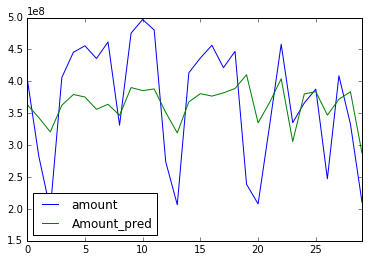

In [79]:
r.reset_index().drop(["index"], axis=1).plot()

## rf

In [181]:
from sklearn.ensemble import RandomForestRegressor

In [226]:
shift = 500
train = pd.get_dummies(train_transactions, columns=['mcc_code'])
#train = pd.get_dummies(X_train, columns=['mcc_code'])
#val = pd.get_dummies(X_val, columns=['mcc_code'])
test = pd.get_dummies(test_transactions, columns=['mcc_code'])

c = train.columns.difference(['amount'])

In [227]:
%%time
rf = RandomForestRegressor(n_estimators=10)

rf.fit(train[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1), np.log(-train['amount'] + shift))

CPU times: user 43.4 s, sys: 1.04 s, total: 44.5 s
Wall time: 45.7 s


In [228]:
pred_rf = np.e ** model.predict(test[c].drop(["month_day","month_num", "week_day", "week_num"], axis=1)) - shift

In [229]:
min(pred_rf)

-195.89685

In [207]:
pred_rf1 = []

for i in pred_rf:
    if i<0:
        i=0
        
    pred_rf1.append(i)

In [208]:
pred_rf2 = []

for i in pred_rf:
    if i<0:
        i += min(pred_rf)
        
    pred_rf2.append(i)

In [230]:
pred_rf3 = pred_rf + abs(min(pred_rf))

In [210]:
RMSLE(abs(X_val.amount),abs(np.array(pred_rf1)),500)

0.44910697611974648

In [269]:
koef_lin = 0.7
koef_rf = 0.15

pred_compos1 = koef_lin*pred_lin + koef_rf*np.array(pred_rf1) + (1-koef_lin-koef_rf)*np.array(pred_xgb3)

In [270]:
test_transactions['volume'] = pred_compos1

In [271]:
test_transactions[['mcc_code', 'day', 'volume']].head()

,mcc_code,day,volume
0,4814,457,1.142653e+07
1,4814,458,1.164858e+07
2,4814,459,1.141537e+07
3,4814,460,1.160741e+07
4,4814,461,1.183274e+07


In [272]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('TASK2_lin_07_rf_015_xgb_drop.csv', index=False)